# Part I. ETL Pipeline for Pre-Processing the Files

## PLEASE RUN THE FOLLOWING CODE FOR PRE-PROCESSING THE FILES

#### Import Python packages 

In [58]:
# Import Python packages 
import pandas as pd
import cassandra
from cassandra.cluster import Cluster
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files

In [2]:
def get_files(path):
    files_path = []
    # traverse all folder and its subfolder from top to bottom
    # Create a for loop to create a list of files and collect each filepath
    for root, dirs, files in os.walk(path):
        # creating a pattern so we only get the path that matches that pattern
        csv_pattern = os.path.join(root, '*.csv')
        file_list = glob.glob(csv_pattern)
        for file in file_list:
            files_path.append(os.path.abspath(file))
    return files_path


In [3]:
# checking your current working directory
print(os.getcwd())

# Get your current folder and subfolder event data
filepath = os.getcwd() + '/event_data'
file_path_list=get_files(filepath)

C:\Users\sror1\data-modeling-apache-cassandra-master


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [4]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:
# reading csv file 
# read only mode
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader) # skip header
        
 # extracting each data row one by one and append it        
        for line in csvreader:
            full_data_rows_list.append(line) 
            
# get total number of rows 
print(len(full_data_rows_list))
# check to see what the list of event data rows will look like
# print(full_data_rows_list)

# creating a smaller event data csv file called event_datafile_new.csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    # only get what matters us in ETL operation
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        # to skip empty row
        if (row[0] == ''):
            continue
        # get the data that would be benficial to us during the operation
        # only 'artist','firstName','gender','itemInSession','lastName','length',\
        # 'level','location','sessionId','song','userId column what matters 
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


8056


In [5]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


# Part II. Complete the Apache Cassandra coding portion of your project. 

## Now you are ready to work with the CSV file titled *event_datafile_new.csv,* located within the workspace directory.  The *event_datafile_new.csv* contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>

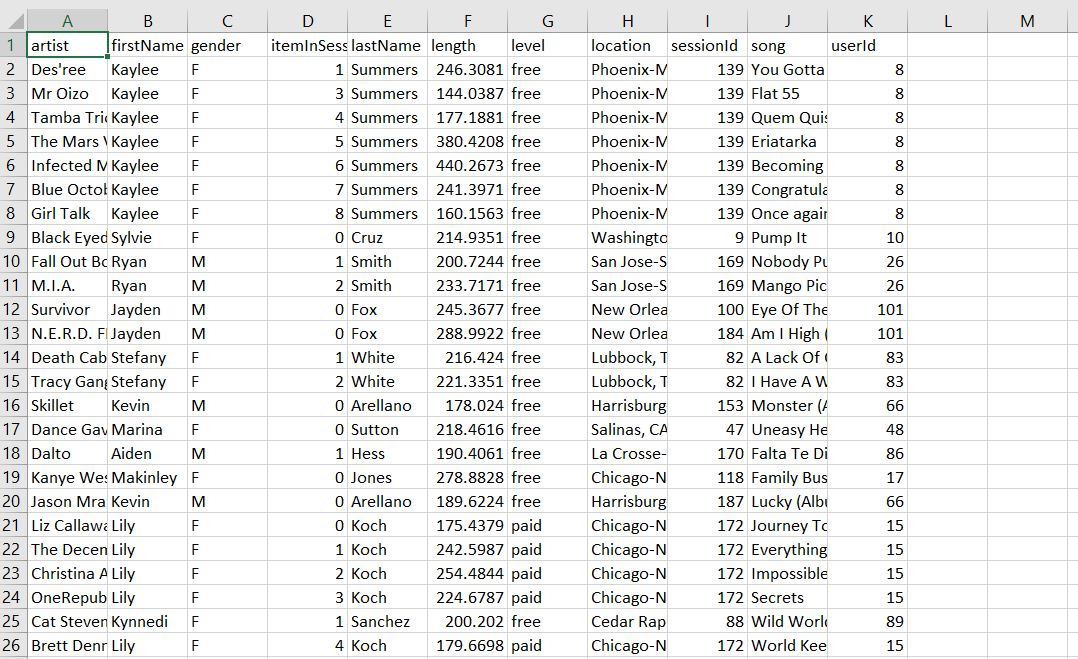

## Begin writing your Apache Cassandra code in the cells below

#### Creating a Cluster

In [7]:
# This should make a connection to a Cassandra instance your local machine 
# (127.0.0.1)
try:
    cluster=Cluster(['127.0.0.1'])
    session=cluster.connect()
    print('successfully created the session')
except Exception as e:
    print(e)


successfully created the session


#### Create Keyspace

In [8]:
try:
    session.execute("""CREATE KEYSPACE IF NOT EXISTS cassandra WITH REPLICATION={'class':'SimpleStrategy','replication_factor':1} """)
    print('successfully created keyspace')

except Exception as e:
    print(e)

successfully created keyspace


#### Set Keyspace

In [9]:
try:
    session.set_keyspace('cassandra')
    print('successfully set the keyspace')
except Exception as e:
    print(e)

successfully set the keyspace


### Now we need to create tables to run the following queries. Remember, with Apache Cassandra you model the database tables on the queries you want to run.

## Create queries to ask the following three questions of the data

### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4


### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
    

### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

In [88]:
query ="CREATE TABLE IF NOT EXISTS  music_app_history"
query=query + "(artist text ,song_title text ,length float,session_id int ,item_in_session int,PRIMARY KEY(session_id,item_in_session))"
try:
    session.execute(query)
except Exception as e:
    print(e)

In [11]:
## Query 1:  Give me the artist, song title and song's length in the music app history that was heard during \
## sessionId = 338, and itemInSession = 4

In [90]:
file = 'event_datafile_new.csv'
music_app_history_insert="""insert into music_app_history (artist ,song_title  ,length ,session_id  ,item_in_session) """
music_app_history_insert = music_app_history_insert + " VALUES (%s, %s, %s, %s, %s)"
with open(file,'r', encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        # Assign the INSERT statements into the `query` variable
        # Assign which column element should be assigned for each column in the INSERT statement.
        session.execute(music_app_history_insert, (line[0], line[9], float(line[5]), int(line[8]), int(line[3])))
print('successfully inserted')

successfully inserted


#### Do a SELECT to verify that the data have been inserted into each table

In [98]:
## TO-DO: Add in the SELECT statement to verify the data was entered into the table
query1="""select artist ,song_title ,length from music_app_history where session_id=338 and item_in_session= 4 """
rows=session.execute(query1)
pd.DataFrame(rows)


,artist,song_title,length
0,Faithless,Music Matters (Mark Knight Dub),495.307312


### COPY AND REPEAT THE ABOVE THREE CELLS FOR EACH OF THE THREE QUESTIONS

### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182

In [92]:
## Query 2: Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name)\
## for userid = 10, sessionid = 182
query ="CREATE TABLE IF NOT EXISTS  user_session"
query=query + """(artist text ,song_title text ,first_name text,last_name text ,user_id int,session_id int,item_in_session int
                ,PRIMARY KEY((user_id,session_id),item_in_session))"""
try:
    session.execute(query)
except Exception as e:
    print(e)

In [93]:
# We have provided part of the code to set up the CSV file. Please complete the Apache Cassandra code below#
file = 'event_datafile_new.csv'
user_session_insert="""insert into user_session (artist ,song_title,first_name ,last_name ,session_id ,item_in_session,user_id) """
user_session_insert = user_session_insert + " VALUES (%s, %s,%s,%s, %s, %s, %s)"
with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        # Assign the INSERT statements into the `query` variable
        # Assign which column element should be assigned for each column in the INSERT statement.
        session.execute(user_session_insert, (line[0], line[9],line[1],line[4],int(line[8]), int(line[3]),int(line[10])))
print('successfully inserted')
        

successfully inserted


In [94]:
## TO-DO: Add in the SELECT statement to verify the data was entered into the table
query2="""select *  from user_session where user_id=10 and session_id= 182 """
rows=session.execute(query2)
pd.DataFrame(rows)



,user_id,session_id,item_in_session,artist,first_name,last_name,song_title
0,10,182,0,Down To The Bone,Sylvie,Cruz,Keep On Keepin' On
1,10,182,1,Three Drives,Sylvie,Cruz,Greece 2000
2,10,182,2,Sebastien Tellier,Sylvie,Cruz,Kilometer
3,10,182,3,Lonnie Gordon,Sylvie,Cruz,Catch You Baby (Steve Pitron & Max Sanna Radio...


### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

In [95]:
## Query 3: Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'
#session.execute('drop table user_music_app_history')
query ="CREATE TABLE IF NOT EXISTS  user_music_app_history"
query=query + """(song text,first_name text,last_name text 
                ,PRIMARY KEY(song,first_name,last_name))"""
try:
    session.execute(query)
except Exception as e:
    print(e)

In [96]:
file = 'event_datafile_new.csv'
user_music_app_history_insert="""insert into user_music_app_history (first_name ,last_name ,song) """
user_music_app_history_insert = user_music_app_history_insert + " VALUES (%s, %s,%s)"

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        # Assign the INSERT statements into the `query` variable
        # Assign which column element should be assigned for each column in the INSERT statement.
        # For e.g., to INSERT artist_name and user first_name, you would change the code below to `line[0], line[1]`
        session.execute(user_music_app_history_insert, (line[1], line[4],line[9]))
print('successfully inserted')
        

successfully inserted


In [97]:
## SELECT statement to verify the data was entered into the table
query3 = "select first_name,last_name from user_music_app_history where song = 'All Hands Against His Own'"
rows=session.execute(query3) 
pd.DataFrame(rows)


,first_name,last_name
0,Jacqueline,Lynch
1,Sara,Johnson
2,Tegan,Levine


### Drop the tables before closing out the sessions

In [ ]:
#Drop the table before closing out the sessions

In [99]:
session.execute('drop table music_app_history')
session.execute('drop table user_session')
session.execute('drop table user_music_app_history')

### Close the session and cluster connection¶

In [100]:
session.shutdown()
cluster.shutdown()